In [1]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import numpy as np
import requests
import random
from io import StringIO
import math
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# Functions

In [3]:
def seed_everything(seed=429):
  """Function to set reproducibility of results"""
  random.seed(seed)
  #os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

In [4]:
def load_data(url):
    response = requests.get(url)
    data_content = response.text
    data_file = StringIO(data_content)
    data = np.loadtxt(data_file)
    return data

In [5]:
class JSLoss(nn.Module):
  def __init__(self):
    super(JSLoss, self).__init__()

  def forward(self, P, Q):
    M = 0.5 * (P + Q)
    JS = 0.5 * (self.KL_div(P, M) + self.KL_div(Q, M)) / torch.log(torch.tensor(2.0))
    scalar_JS = torch.mean(JS)
    # print(scalar_JS)
    return scalar_JS

  def KL_div(self, P, Q):
    P = torch.clamp(P, min = 1e-15)  # Clip values to prevent log(0)
    Q = torch.clamp(Q, min = 1e-15)
    return torch.sum(P * torch.log(P / Q), dim = 2)  # Adjust dimensions as needed

In [6]:
class CustomLayer(nn.Module):
  def __init__(self, n_lower : int, n_upper : int, bin_lower : int, bin_upper : int,
               weight_init = 0.1, weight_init_method = 'uniform'):
    super(CustomLayer, self).__init__()
    self.n_lower = n_lower
    self.n_upper = n_upper
    self.bin_lower = bin_lower
    self.bin_upper = bin_upper
    self.weight_init = weight_init
    self.weight_init_method = weight_init_method

    self.init_weights()
    self.D = self.initD()


  def init_weights(self):
    initializers = {
              'uniform': init.uniform_,
              'normal': init.normal_,
              'glorot_normal': init.xavier_normal_
          }
    initializer = initializers.get(self.weight_init_method, init.uniform_)

    self.weights = nn.Parameter(torch.empty((self.n_upper, self.n_lower)))
    self.abs_bias = nn.Parameter(torch.empty(self.n_upper, 1))
    self.quad_bias = nn.Parameter(torch.empty(self.n_upper, 1))
    self.abs_lambda = nn.Parameter(torch.empty(self.n_upper, 1).uniform_(0.0, 1.0))
    self.quad_lambda = nn.Parameter(torch.empty(self.n_upper, 1).uniform_(0.0, 1.0))

    if self.weight_init_method == 'uniform':
      for param in [self.weights, self.abs_bias, self.quad_bias]:
        initializer(param, a = -self.weight_init, b = self.weight_init)
    else:
      for param in [self.weights, self.abs_bias, self.quad_bias]:
        initializer(param)


  def initD(self):
    si = np.arange(self.bin_lower, dtype = float)
    sk = np.arange(self.bin_upper, dtype = float)

    si_mat = np.tile(si, (self.bin_upper, 1))
    sk_mat = np.tile(sk[:, np.newaxis], (1, self.bin_lower))

    D_np = np.exp(-((sk_mat / self.bin_upper - si_mat / self.bin_lower) ** 2))
    D_tensor = torch.tensor(D_np[..., np.newaxis, np.newaxis], dtype=torch.float32)
    D = D_tensor.expand(-1, -1, self.n_upper, self.n_lower)
    return D


  def cal_logexp_bias(self):
    s0 = torch.arange(self.bin_upper, dtype=torch.float32).reshape(1, self.bin_upper)
    B = -self.quad_bias * (s0 / self.bin_upper - self.quad_lambda) ** 2 - self.abs_bias * torch.abs(s0 / self.bin_upper - self.abs_lambda)  # nu x qu
    return B


  def forward(self, x):
    P_reshaped = torch.reshape(x, [-1, 1, self.n_lower, self.bin_lower, 1])
    Ptile = torch.tile(P_reshaped, [1, self.n_upper, 1, 1, 1])  # bs x nu x nl x ql x 1
    T = torch.permute(torch.pow(self.D, self.weights), [2, 3, 0, 1]) # nu x nl x qu x ql

    # Einstein summation : sum(P(s) * e^{wD})
    Pw_unclipped = torch.squeeze(torch.einsum('jklm,ijkmn->ijkln', T, Ptile), dim = 4)
    Pw = torch.clamp(Pw_unclipped, 1e-15, 1e+15)

    # unnormalized p(sk) = e^{B_sk} * sum
    # unnormalized P(sk) = B_sk + logsum
    logPw = torch.log(Pw)
    logsum = torch.sum(logPw, dim = 2)
    B_sk = self.cal_logexp_bias()
    logsumB = logsum + B_sk

    # Normalization
    max_logsum = torch.max(logsumB, dim = 2, keepdim = True).values
    expm_P = torch.exp(logsumB - max_logsum)
    Z = torch.sum(expm_P, dim=2, keepdim = True)
    ynorm = expm_P / Z

    return ynorm

In [7]:
class CustomNet(nn.Module):
  def __init__(self, in_dim : int, num_hidden: int, hidden_dim : int,
               out_dim : int, bin : int, hidden_bin : int):
    super(CustomNet, self).__init__()
    self.in_dim = in_dim
    self.num_hidden = num_hidden
    self.hidden_dim = hidden_dim
    self.out_dim = out_dim
    self.bin = bin
    self.hidden_bin = hidden_bin

    if self.num_hidden == 0:
      self.in_layer = CustomLayer(self.in_dim, self.out_dim, self.bin, self.bin)
    else:
      self.in_layer = CustomLayer(self.in_dim, self.hidden_dim, self.bin, self.hidden_bin)
      for layer in range(num_hidden - 1):
        setattr(self, f'hidden_{layer}', CustomLayer(self.hidden_dim, self.hidden_dim, self.hidden_bin, self.hidden_bin))
      self.out_layer = CustomLayer(self.hidden_dim, self.out_dim, self.hidden_bin, self.bin)


  def forward(self, x):
    for i, layer in enumerate(self.children()):
      # print(i)
      x = layer(x)
    return x

In [8]:
def train(model, train_loader, criterion, optimizer):
  model.train()
  running_loss = 0.0
  for batch_idx, (inputs, targets) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # batch_idx += 1
    # if batch_idx % 10 == 0:
    #   print(f'Epoch [{epoch+1}/{epochs}]  Batch [{batch_idx}/{len(train_loader)}]  Loss: {running_loss / batch_idx:.6f}')

  epoch_loss = running_loss / len(train_loader)
  print(f'Epoch [{epoch+1}/{epochs}]  Training Loss: {epoch_loss:.6f}')
  return epoch_loss

def validate(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  num_samples = 0
  for batch_idx, (inputs, targets) in enumerate(val_loader):
    with torch.no_grad():
      outputs = model(inputs)
    loss = criterion(outputs, targets)
    running_loss += loss.item()
    num_samples += targets.size(0)
    # batch_idx += 1
    # if batch_idx % 10 == 0:
    #   print(f'Epoch [{epoch+1}/{epochs}]  Batch [{batch_idx}/{len(val_loader)}]  Loss: {running_loss / batch_idx:.6f}')

  epoch_loss = running_loss / len(val_loader)
  print(f'Epoch [{epoch+1}/{epochs}] Validation Loss: {running_loss/len(val_loader):.6f}')
  return epoch_loss

# Config

In [9]:
seed = 0
epochs = 300
lr = 0.1
train_batch_size = 10
val_batch_size = 10
# load_model = False

in_dim = 1
num_hidden = 1
hidden_dim = 1
out_dim = 1
bin = 100
hidden_bin = 10

Ntrain = 100
Nval = 100

# Load Data

In [10]:
# url
# val_x_url = 'https://raw.githubusercontent.com/koukl/drn/master/OU_q100/test_x.dat'
# val_y_url = 'https://raw.githubusercontent.com/koukl/drn/master/OU_q100/test_y.dat'
# train_x_url = 'https://raw.githubusercontent.com/koukl/drn/master/OU_q100/train_x.dat'
# train_y_url = 'https://raw.githubusercontent.com/koukl/drn/master/OU_q100/train_y.dat'

# # load data from url
# train_x_complete = load_data(train_x_url) # (2500, 100)
# train_y_complete = load_data(train_y_url) # (2500, 100)
# val_x_complete = load_data(val_x_url) # (2500, 100)
# val_y_complete = load_data(val_y_url) # (2500, 100)

train_x_complete = np.loadtxt('/content/drive/MyDrive/Adv/OU data/train_x.dat')
train_y_complete = np.loadtxt('/content/drive/MyDrive/Adv/OU data/train_y.dat')
val_x_complete = np.loadtxt('/content/drive/MyDrive/Adv/OU data/test_x.dat')
val_y_complete = np.loadtxt('/content/drive/MyDrive/Adv/OU data/test_y.dat')

# reshape dim of data
train_x = train_x_complete[:Ntrain].reshape((-1, 1, bin)) # (100, 1, 100)
train_y = train_y_complete[:Ntrain].reshape((-1, 1, bin)) # (100, 1, 100)
val_x = val_x_complete[:Nval].reshape((-1, 1, bin)) # (100, 1, 100)
val_y = val_y_complete[:Nval].reshape((-1, 1, bin)) # (100, 1, 100)

x = np.concatenate((train_x, val_x), axis=0)
y = np.concatenate((train_y, val_y), axis=0)

# Convert data arrays to PyTorch tensors
x_tensor = torch.tensor(x, dtype = torch.float32)
y_tensor = torch.tensor(y, dtype = torch.float32)

In [11]:
import torch

def generate_5_fold_cv(x_tensor, y_tensor):
    """
    Generate training and validation folds for 5-fold cross-validation while preserving
    the correspondence between x and y tensors.

    Args:
        x_tensor (torch.Tensor): The input tensor containing x values.
        y_tensor (torch.Tensor): The label tensor.

    Returns:
        List of tuples: Each tuple contains training x, training y, validation x, and validation y tensors.
    """
    # Define the number of folds
    num_folds = 5

    # Calculate the size of each fold
    fold_size = len(x_tensor) // num_folds

    # Create a list to store the folds
    folds = []

    # Split the data into 5 folds
    for i in range(num_folds):
        start = i * fold_size
        end = (i + 1) * fold_size if i < num_folds - 1 else None
        val_x_fold = x_tensor[start:end]  # Validation x fold
        val_y_fold = y_tensor[start:end]  # Validation y fold
        train_x_fold = torch.cat([x_tensor[:start], x_tensor[end:]], dim=0)  # Training x fold
        train_y_fold = torch.cat([y_tensor[:start], y_tensor[end:]], dim=0)  # Training y fold
        folds.append((train_x_fold, train_y_fold, val_x_fold, val_y_fold))

    return folds

# Example usage:
# Assuming 'x_tensor' and 'y_tensor' are your input tensors
# Get the folds using the function
# folds = generate_5_fold_cv(x_tensor, y_tensor)

# 'folds' will contain 5 tuples, each with training x, training y, validation x, and validation y tensors.


# Model Training

In [12]:
folds = generate_5_fold_cv(x_tensor, y_tensor)

oof_train_losses = []
oof_val_losses = []

for train_x_fold, train_y_fold, val_x_fold, val_y_fold in folds:
  # Model Initialization
  seed_everything(seed)
  model = CustomNet(in_dim, num_hidden, hidden_dim, out_dim, bin, hidden_bin)
  # criterion = nn.MSELoss()
  criterion = JSLoss()
  optimizer = optim.Adam(model.parameters(), lr = lr) # weight_decay
  train_dataset = TensorDataset(train_x_fold, train_y_fold)
  val_dataset = TensorDataset(val_x_fold, val_y_fold)

  train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
  val_loader = DataLoader(val_dataset, batch_size = val_batch_size, shuffle = False)

  train_losses = []
  val_losses = []

  # Training Loop
  for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss = validate(model, val_loader, criterion)
    val_losses.append(val_loss)

  oof_train_losses.append(train_losses)
  oof_val_losses.append(val_losses)

print('Finished Training and Testing, YAY!!!!!')

Epoch [1/300]  Training Loss: 0.318068
Epoch [1/300] Validation Loss: 0.264890
Epoch [2/300]  Training Loss: 0.248187
Epoch [2/300] Validation Loss: 0.212705
Epoch [3/300]  Training Loss: 0.215852
Epoch [3/300] Validation Loss: 0.186698
Epoch [4/300]  Training Loss: 0.199514
Epoch [4/300] Validation Loss: 0.176444
Epoch [5/300]  Training Loss: 0.194727
Epoch [5/300] Validation Loss: 0.163961
Epoch [6/300]  Training Loss: 0.180520
Epoch [6/300] Validation Loss: 0.163066
Epoch [7/300]  Training Loss: 0.168832
Epoch [7/300] Validation Loss: 0.165430
Epoch [8/300]  Training Loss: 0.162749
Epoch [8/300] Validation Loss: 0.145190
Epoch [9/300]  Training Loss: 0.152814
Epoch [9/300] Validation Loss: 0.148201
Epoch [10/300]  Training Loss: 0.151128
Epoch [10/300] Validation Loss: 0.169881
Epoch [11/300]  Training Loss: 0.145650
Epoch [11/300] Validation Loss: 0.129128
Epoch [12/300]  Training Loss: 0.139750
Epoch [12/300] Validation Loss: 0.121106
Epoch [13/300]  Training Loss: 0.127177
Epoch 

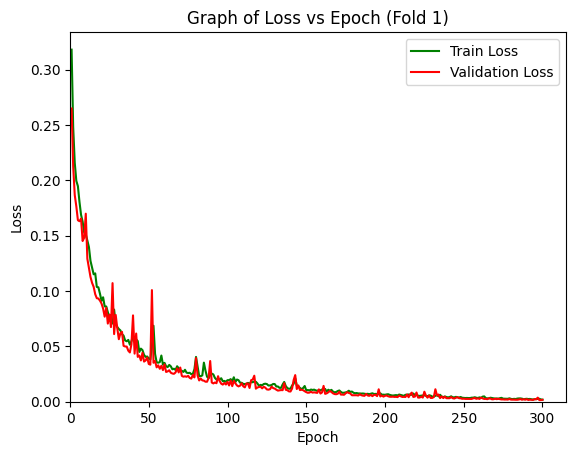

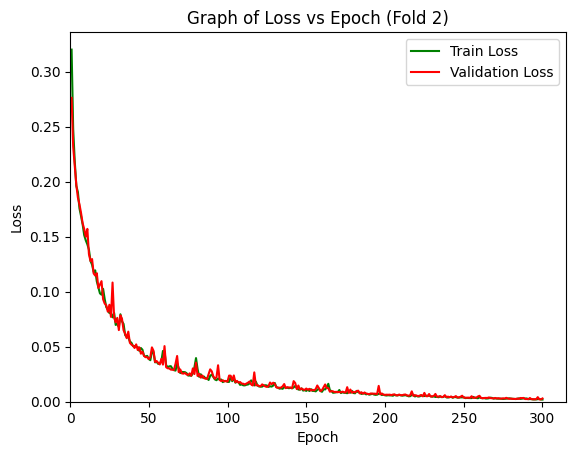

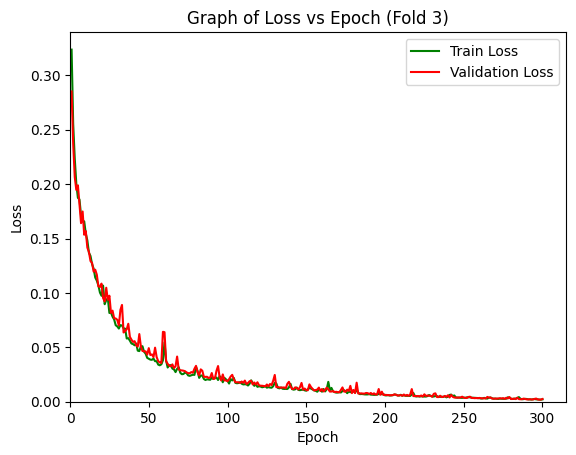

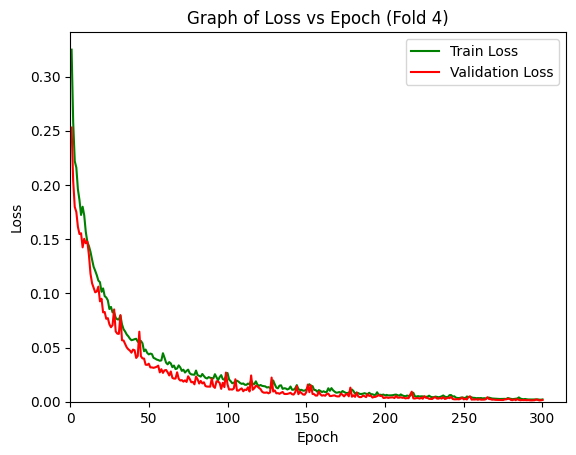

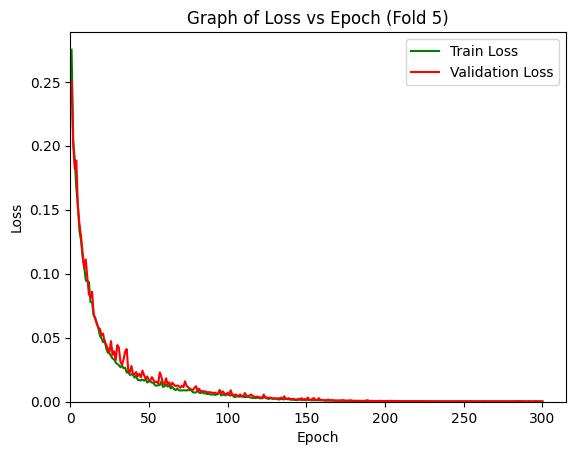

In [17]:
oof_epochs = [list(range(1, epochs+1)) for _ in range(epochs)]

for i in range(5):

    plt.plot(oof_epochs[0], oof_train_losses[i], 'g-', label='Train Loss')
    plt.plot(oof_epochs[0], oof_val_losses[i], 'r-', label='Validation Loss')

    plt.title(f"Graph of Loss vs Epoch (Fold {i+1})")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.xlim(0)
    plt.ylim(0)
    plt.legend()
    plt.show()

In [18]:
oof_train_losses[0]

[0.3180678505450487,
 0.24818727187812328,
 0.2158523127436638,
 0.199513946659863,
 0.194726699963212,
 0.1805197955109179,
 0.1688323705457151,
 0.16274938033893704,
 0.15281424345448613,
 0.1511282087303698,
 0.14564954116940498,
 0.13975033164024353,
 0.12717701541259885,
 0.12118785455822945,
 0.11510869907215238,
 0.11592811858281493,
 0.10370956314727664,
 0.10337124764919281,
 0.09763609990477562,
 0.09114759229123592,
 0.09436148684471846,
 0.08613089611753821,
 0.08603553380817175,
 0.08089866815134883,
 0.07587502454407513,
 0.07343375496566296,
 0.07060766406357288,
 0.08324148342944682,
 0.07012194860726595,
 0.06748807895928621,
 0.0656844093464315,
 0.0643875461537391,
 0.06105696246959269,
 0.05972707411274314,
 0.05531364539638162,
 0.05462769418954849,
 0.055846601724624634,
 0.05148028256371617,
 0.054677785374224186,
 0.058959780260920525,
 0.05356126883998513,
 0.05633685411885381,
 0.0547905748244375,
 0.044958916725590825,
 0.04795338644180447,
 0.046628916752524

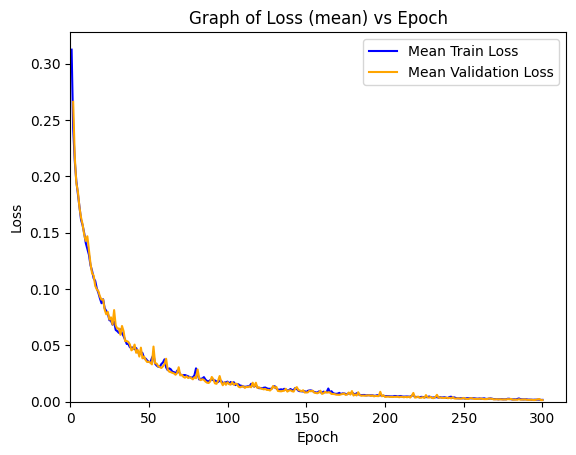

In [19]:
mean_oof_train_loss = np.mean(oof_train_losses, axis=0).tolist()
mean_oof_val_loss = np.mean(oof_val_losses, axis=0).tolist()
# # Create a figure
# plt.figure()

# Plot the mean training and validation losses across epochs
plt.plot(oof_epochs[0], mean_oof_train_loss, 'b-', label='Mean Train Loss')
plt.plot(oof_epochs[0], [None] + mean_oof_val_loss[:-1], color = 'orange', linestyle = '-', label='Mean Validation Loss')

plt.title("Graph of Loss (mean) vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xlim(0)
plt.ylim(0)
plt.legend()

plt.show()

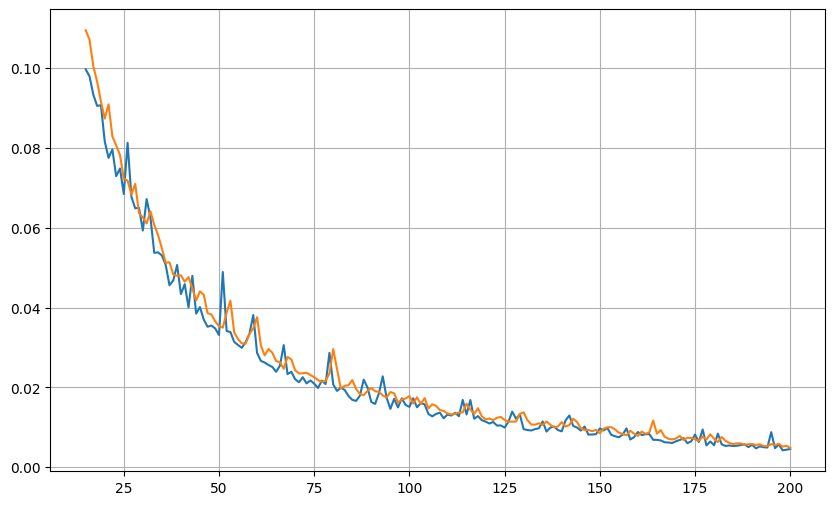

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have train_losses and val_losses lists defined
# with loss values for all epochs

start_epoch = 15  # Set the epoch from which you want to start plotting
end_epoch = 201

plt.figure(figsize=(10, 6))

sns.lineplot(x = range(start_epoch, end_epoch), y = mean_oof_val_loss[start_epoch:end_epoch])
sns.lineplot(x = range(start_epoch, end_epoch), y = mean_oof_train_loss[start_epoch-1:end_epoch-1])  # Shifted validation loss by 1 epoch

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Losses vs Epoch (From Epoch {} onwards)'.format(start_epoch))
# plt.legend()
plt.grid(True)
plt.show()

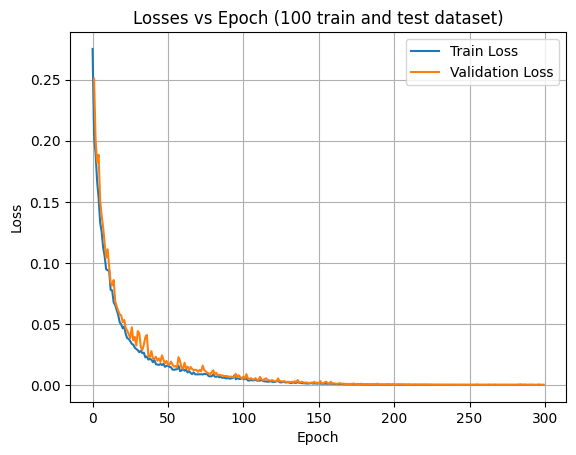

In [21]:
sns.lineplot(train_losses, label = 'Train Loss')
# sns.lineplot(val_losses, label = 'Validation Loss')
sns.lineplot([None] + val_losses[:-1], label = 'Validation Loss') # Shifting validation loss by 1 epoch
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses vs Epoch (100 train and test dataset)')
plt.legend()
plt.grid(True)
plt.show()

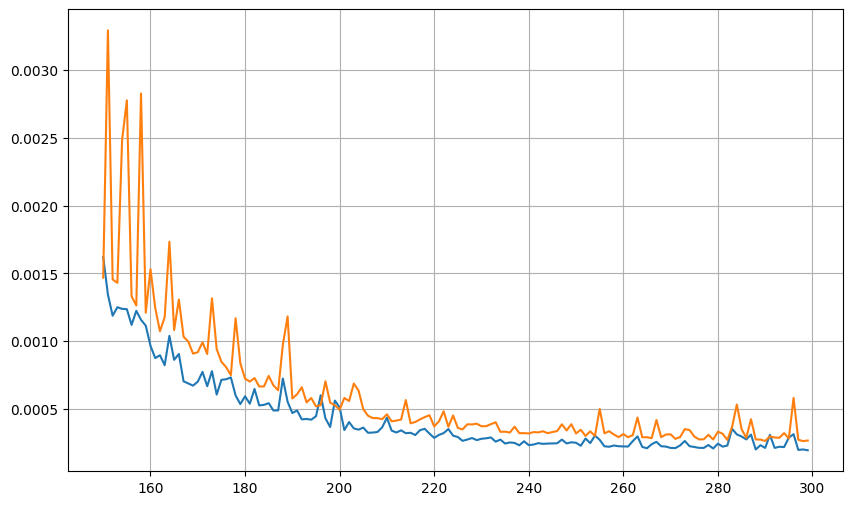

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have train_losses and val_losses lists defined
# with loss values for all epochs

start_epoch = 150  # Set the epoch from which you want to start plotting

plt.figure(figsize=(10, 6))

sns.lineplot(x = range(start_epoch, len(train_losses)), y = train_losses[start_epoch:])
sns.lineplot(x = range(start_epoch, len(val_losses)), y = val_losses[start_epoch-1:-1])  # Shifted validation loss by 1 epoch

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Losses vs Epoch (From Epoch {} onwards)'.format(start_epoch))
# plt.legend()
plt.grid(True)
plt.show()


# Extra

In [ ]:
def initD(ql, qu, nl, nu):
  D_np = np.zeros((qu, ql))

  for s1 in range(qu):
    for s0 in range(ql):
      D_np[s1, s0] = np.exp(-((float(s0)/ql - float(s1)/qu) ** 2))
  Dnp = D_np.reshape((qu, ql, 1, 1))
  D_tensor = torch.tensor(Dnp, dtype=torch.float32)
  D = torch.tile(D_tensor, [1, 1, nu, nl])
  return D

def initD2(bin_lower, bin_upper, n_lower, n_upper):
    si = np.arange(bin_lower, dtype = float)
    sk = np.arange(bin_upper, dtype = float)

    si_mat = np.tile(si, (bin_upper, 1))
    sk_mat = np.tile(sk[:, np.newaxis], (1, bin_lower))

    D_np = np.exp(-((sk_mat / bin_upper - si_mat / bin_lower) ** 2))
    D_tensor = torch.tensor(D_np[..., np.newaxis, np.newaxis], dtype=torch.float32)
    D = D_tensor.expand(-1, -1, n_upper, n_lower)

    return D

ql = 100
qu = 100
nl = 100
nu = 100

start_time = time.time()
D_np_loop = initD(ql, qu, nl, nu)
loop_time = time.time() - start_time

start_time = time.time()
D_np_vectorized = initD2(ql, qu, nl, nu)
vectorized_time = time.time() - start_time

print("Loop-based implementation time:", loop_time)
print("Vectorized implementation time:", vectorized_time)

In [ ]:
# val_x_complete = load_data(val_x_url) # (2500, 100)
# val_y_complete = load_data(val_y_url) # (2500, 100)

val_x_complete = np.loadtxt('/content/drive/MyDrive/Adv/OU data/test_x.dat')
print(val_x_complete.shape)
val_y_complete = np.loadtxt('/content/drive/MyDrive/Adv/OU data/test_y.dat')

test_x = val_x_complete[Nval: Nval + 5]
test_y = val_y_complete[Nval: Nval + 5]

test_x_tensor = torch.tensor(test_x, dtype = torch.float32)
test_y_tensor = torch.tensor(test_y, dtype = torch.float32)

test_dataset = TensorDataset(test_x_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size = 5, shuffle = False)

model.eval()
with torch.no_grad():
  for batch in test_loader:
    x, y = batch
    y_hat = model(x)
    break

  batch_size, sequence_length = x.shape
  time_steps = range(sequence_length)

  for batch_idx in range(batch_size):
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, x[batch_idx], label='x')
    plt.plot(time_steps, y[batch_idx], label='y')
    plt.plot(time_steps, y_hat[batch_idx][0], label='y_hat')

    plt.xlabel('x', fontsize = 30)
    plt.ylabel('P(x)', fontsize = 30)
    plt.tick_params(axis='x', labelsize=25)
    plt.tick_params(axis='y', labelsize=25)
    plt.title('Comparison of x, y, and y_hat', fontsize = 25)
    plt.legend(fontsize = 25)
    plt.grid(True)
    plt.show()